# Relatorio do Trabalho 2

#### Professor: Ivan Robert Enriquez Guzman

#### Alunos:
- Hugo Batista da Silva
- João Paulo de Paiva Holz

## Introdução

Eventos raros ou extremos têm grande relevância na climatologia e hidrologia, e suas estimativas probabilísticas são imprescindíveis para o planejamento e desenvolvimento das atividades sujeitas a seus efeitos adversos, especialmente estruturas de engenharia civil e agricultura. Por isso é de extrema importância analisar variáveis para estudar tendências, e podemos fazer isso com métodos regressivos usando séries temporais.

### Sobre o dataset

#### Fonte: [Dados de tempo Inmet - Kaggle](https://www.kaggle.com/datasets/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region)


### Dados que utilizaremos

Escolhemos 4 estações meteorologicas para trabalhar com os dados. 

<br>


Codigo|Cidade
---|---
A612|Vitoria - Ufes
A634|Vila Velha
A614|Linhares
A613|Santa Teresa

<br>
    
    
Mantivemos temperatura maxima na hora anterior, precipitação total, pressao atmosferica ao nivel da estacao e rajada de vento maxima na hora, total de 4 covariaveis de 4 estações meteorologicas diferentes, 16 variaveis aleatorias, onde utilizaremos 4 como reposta e 12 como variaveis preditoras


## Importando Bibliotecas

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
#from jh_utils.data.pandas.preprocessing import make_dummies
from get_df import get_data_for_ml,keep_cols,small_column_names_for_mldf
from plot import lines_plot, columnX, plot_ccf_sm, cross_plots
import seaborn as sns
import statsmodels.tsa.stattools as smt
from get_df import get_data_for_ml,keep_cols, get_data, get_dfs_for_ml
from itertools import combinations,permutations

## Importando Dados

In [15]:
df,df_just_stocastic = get_dfs_for_ml('temperatura maxima na hora ant.')
df_just_stocastic.columns = df_just_stocastic.columns

_,precipitacao = get_dfs_for_ml()
precipitacao.columns = precipitacao.columns + '_volume_chuva'
precipitacao = precipitacao.iloc[:,1:]

_,stp = get_dfs_for_ml('pressao atmosferica ao nivel da estacao')
stp.columns = stp.columns + '_pressao'
stp = stp.iloc[:,1:]

_,gust = get_dfs_for_ml('vento rajada maxima')
gust.columns = gust.columns + '_vento'
gust = gust.iloc[:,1:]

/home/joaoholz/Documents/LSTAT/joao/trabalho2/get_df.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df.date_time.dt.weekofyear
/home/joaoholz/Documents/LSTAT/joao/trabalho2/get_df.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df.date_time.dt.weekofyear
/home/joaoholz/Documents/LSTAT/joao/trabalho2/get_df.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df.date_time.dt.weekofyear
/home/joaoholz/Documents/LSTAT/joao/trabalho2/get_df.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df.date_time.dt.weekofyear


In [16]:
variables = pd.concat([df_just_stocastic.iloc[:,1:],precipitacao,stp,gust],axis=1)

## Analise Exploratoria de Dados

vemos que aa variavel que possui maior correlação entre as estações é o vento e a temperatura máxima entre as estações.
fora selecionado justamente essas variáveis para realizar os modelos e testes para não haver homecedasticidade. Percebemos também que
a variável pressão é a que possui menos correlação entre as estações (futuramente ela será excluída das análises por não apresentar diferença
nos gráficos dos testes)

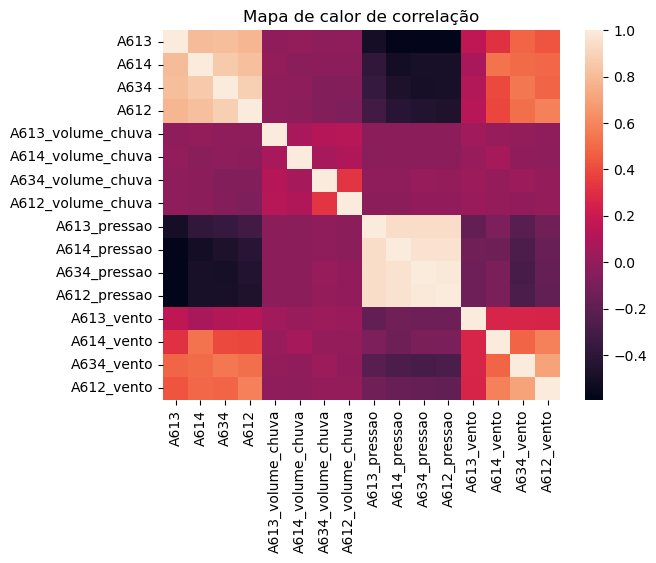

In [17]:
_ = sns.heatmap(variables.corr())
_ = plt.title('Mapa de calor de correlação')

Observando o gráfico da temperatura máxima das estações vemos que apenas as barras de Santa Teresa que possui uma média muito distante das demais.
Isso se deve ao fato de que o clima em Santa Teresa ser mais frio na maioria dos dias do ano em comparação aos outros municípios do ES. Vemos que
a temperatura de 25° C é a que mais possui volume de dados para o restante das estações.

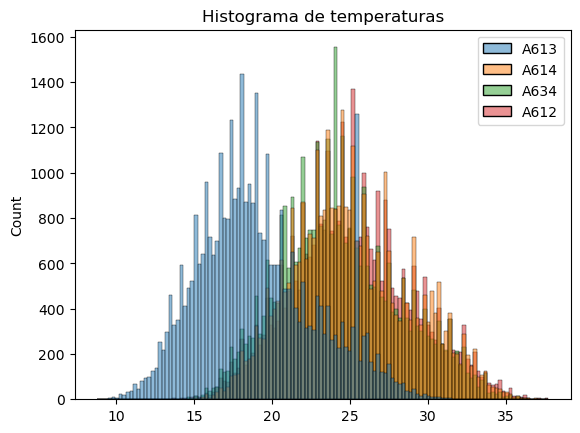

In [18]:
_ = sns.histplot(df_just_stocastic)
_ = plt.title('Histograma de temperaturas')

comparando os dois gráficos da evolução da temperatura máxima durante os meses vemos que santa teresa sempre se manteve abaixodas demais estações
e houve alguns picos de temperatura para vila velha no final do ano de 2017.


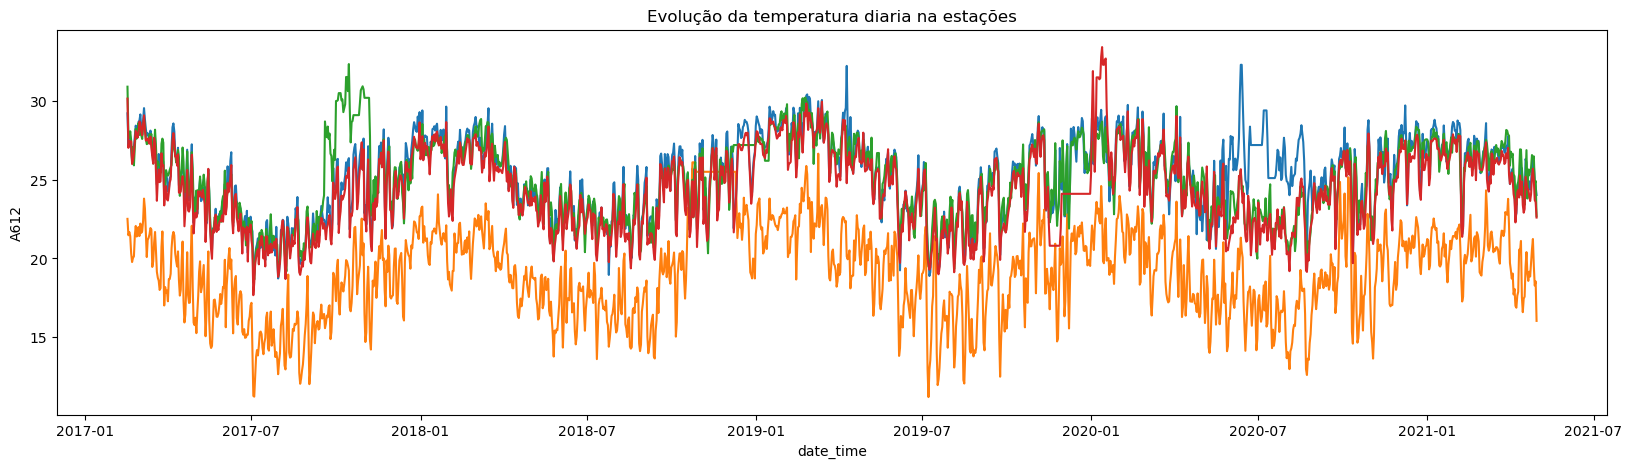

In [20]:
_ = lines_plot(df_just_stocastic,['A612','A613','A614','A634'],freq='D')
_ = plt.title('Evolução da temperatura diaria na estações')

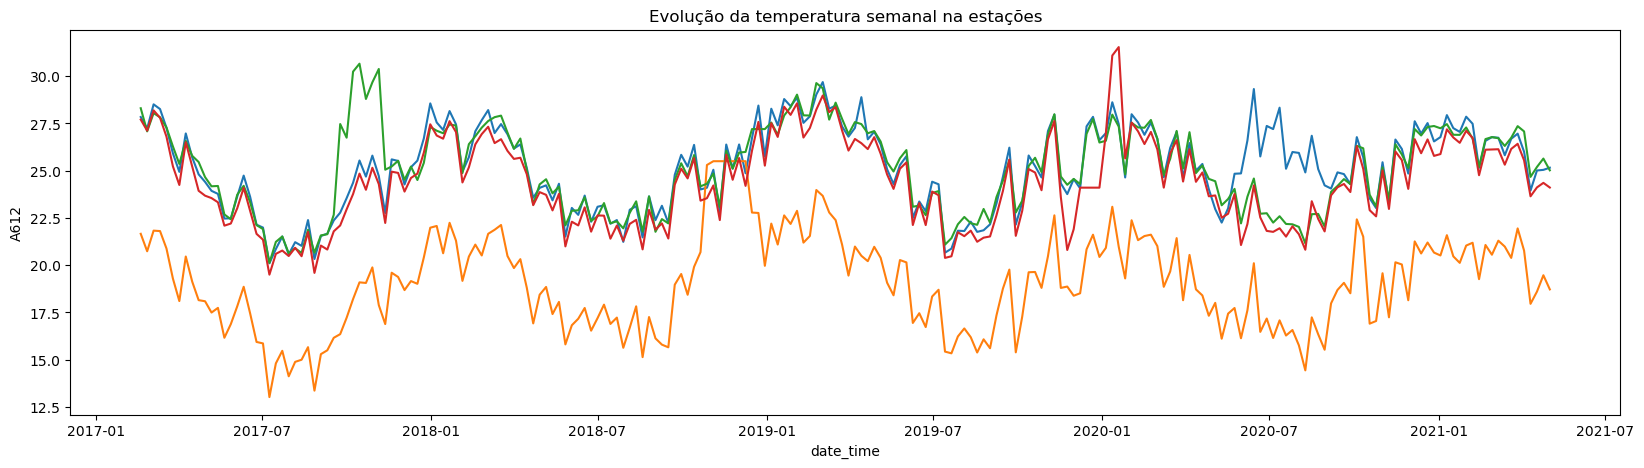

In [21]:
_ = lines_plot(df_just_stocastic,['A612','A613','A614','A634'],freq='w')
_ = plt.title('Evolução da temperatura semanal na estações')

Vemos que as temperaturas máximas cruzadas pelas estações seguemuma distribuição que se assemelha à normal e na nuvem de pontos há um comportamento linear.

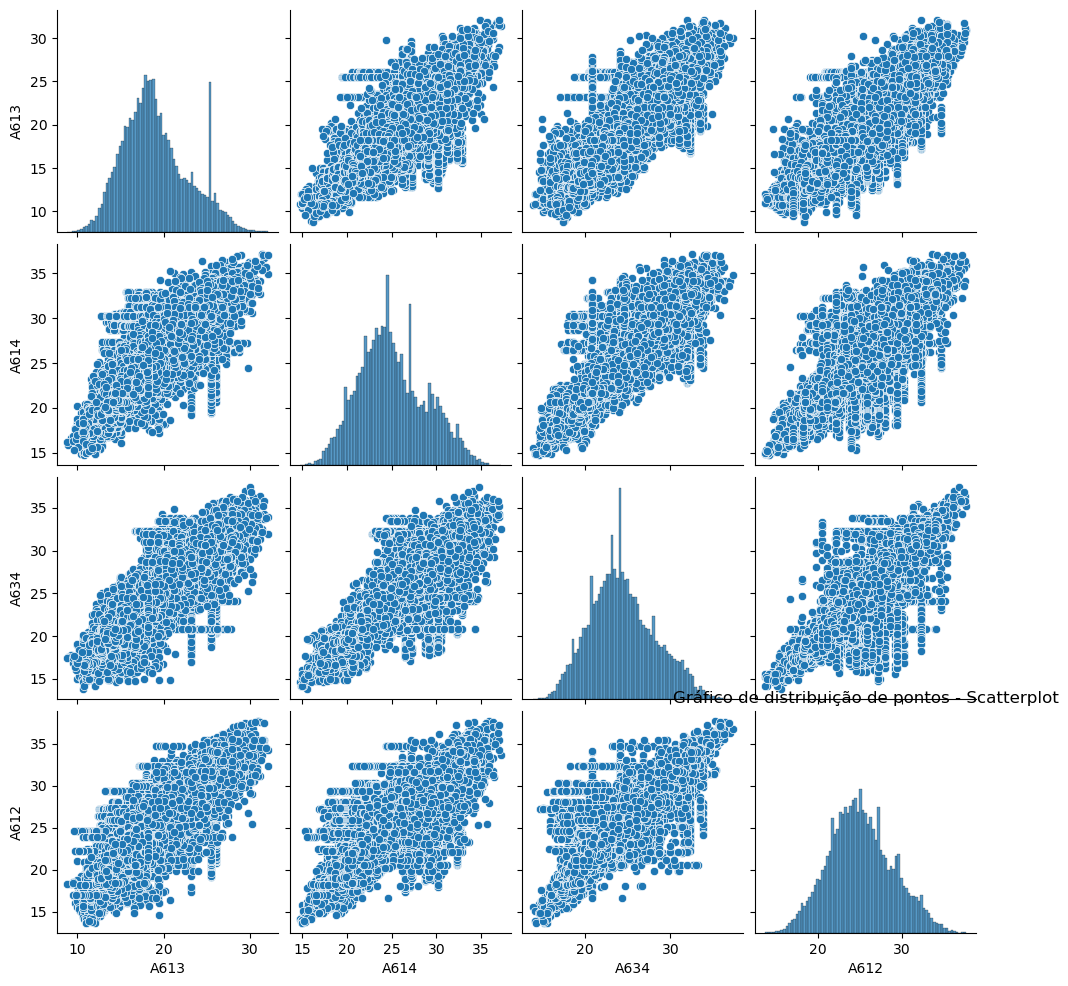

In [22]:
_ = sns.pairplot(df_just_stocastic)
_ = plt.title('Gráfico de distribuição de pontos - Scatterplot')

## Modelo

## Autocorrelação e Autocorrelação parcial 

Uma análise de série temporal simples é sempre uma análise sobre o que já aconteceu na própria série e com a correlação não seria diferente. Uma correlação nos diz o quão relacionado é um valor com outro valor (isso não significa que um valor influenciou o outro) e uma autocorrelação (ACF) é quando comparamos o valor do presente com valores do passado da mesma série. A diferença entre a autocorrelação e a autocorrelação parcial (PACF) é quase um detalhe: em uma ACF temos a correlação direta e indireta e em uma PACF apenas a correlação direta. Exemplificando, com a ACF vemos a correlação direta do mês de janeiro em março e também a correlação indireta que o mês de janeiro teve em fevereiro que também teve em março.  

## Modelos para Séries Temporais
### Autorregressão (AR)}
Uma autoregressão é basicamente uma regressão onde seus parâmetros são regressões em tempos anteriores.

$$ X(t) = a + b_1x(t - 1) + b_2x(t - 2) + ... + b_nx(t - n)$$

Onde $a$, $b_1$, $b_2$, ... , $b_n$ são os coeficientes da regressão e $t$ é o indicador de qual tempo estamos usando na regressão $X$.

### Moving Average Model (MA)}
Apesar do nome o Moving Average Model não é a mesma coisa que apenas calcular a média móvel da série temporal. O MA é um modelo linear, assim como a regressão, que usa os resíduos dos passos anteriores como variáveis. Esses resíduos são calculados a partir da diferença com a média dessa série, tendo uma série que se move em volta da sua média.

$$ X_t = \mu + \epsilon_t + \theta_1\epsilon_{t-1} + ... + \theta_q\epsilon_{t-q}$$

Onde $\mu$ é a média da série, $\epsilon$ são os resíduos de acordo com o tempo $t$ até $t - q$ e $\theta$ são os coeficientes de cada variável.

O modelo MA pode ser usado como parte do modelo ARMA (AR + MA) deixando a ordem da AR em zero.

## Notas para o nosso modelo
Para montarmos o nosso modelo vamos utilizar acfs e pacfs e cross correlation para viabilizar o uso de um modelo VAR

Definiremos nosso Y como sendo a tempratura maxima das estações.   
As Covariaveis utilizaremos as que deram relevante na apresentação passada utilizando CrossCorrelation.   

### ACFS

ACFs abaixo vemos esse comportamento de senoide com periodo de 24. Como temos uma serie horário já era esperado. Vamos utilizar esse periodo como lag no modelox

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

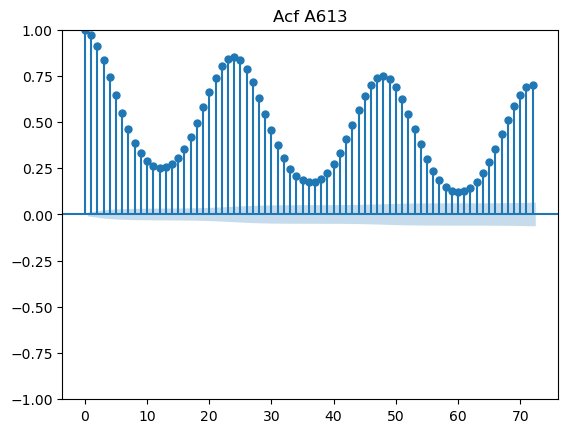

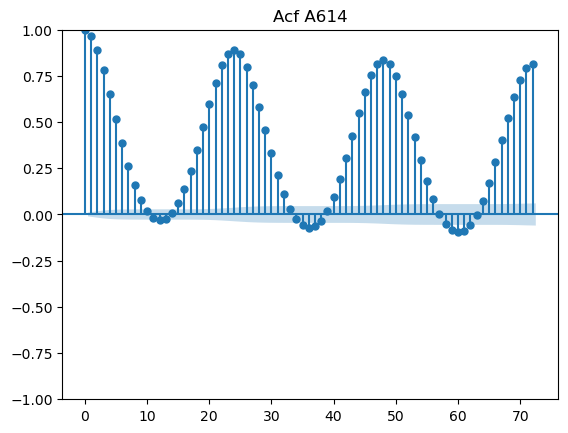

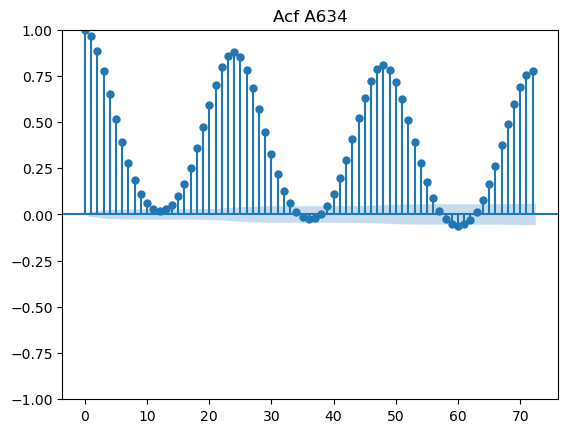

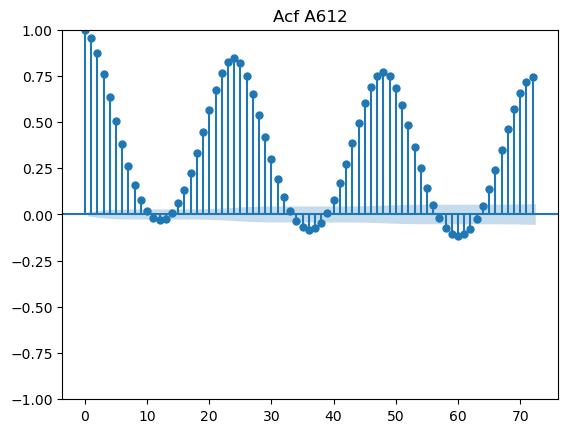

In [37]:
_ = plot_acf(df_just_stocastic.iloc[:,1],lags=72)
_ = plt.title('Acf '+ df_just_stocastic.columns[1])
_ = plot_acf(df_just_stocastic.iloc[:,2],lags=72)
_ = plt.title('Acf '+ df_just_stocastic.columns[2])
_ = plot_acf(df_just_stocastic.iloc[:,3],lags=72)
_ = plt.title('Acf '+ df_just_stocastic.columns[3])
_ = plot_acf(df_just_stocastic.iloc[:,4],lags=72)
_ = plt.title('Acf '+ df_just_stocastic.columns[4])

### PACFS

/home/joaoholz/miniconda3/envs/lestat/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


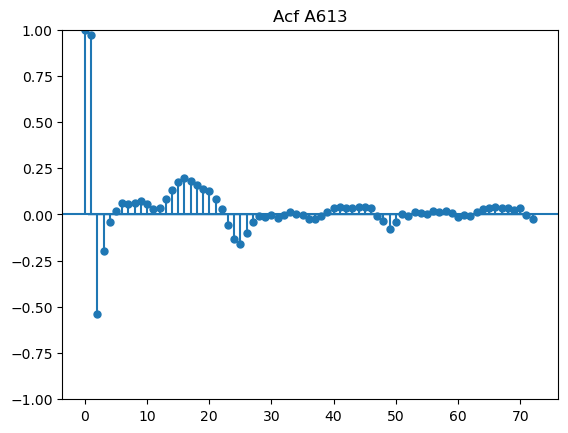

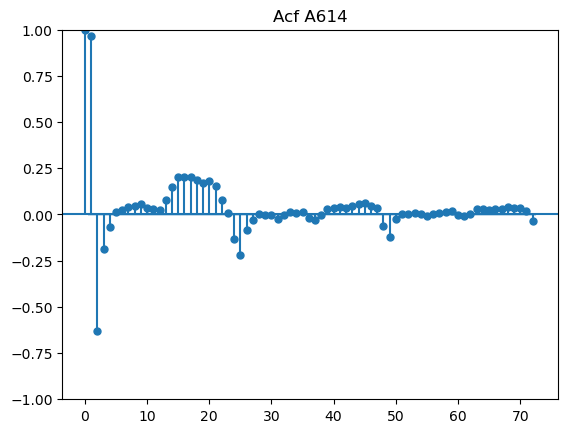

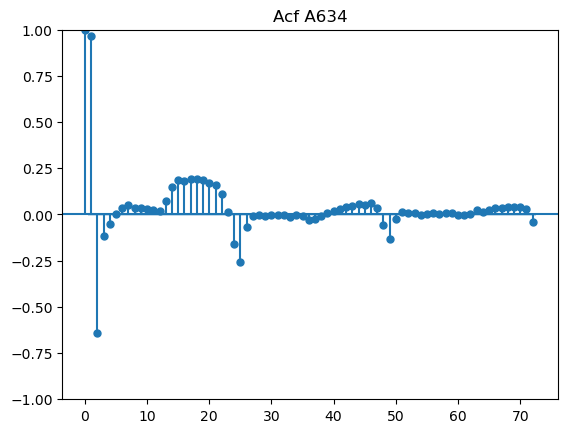

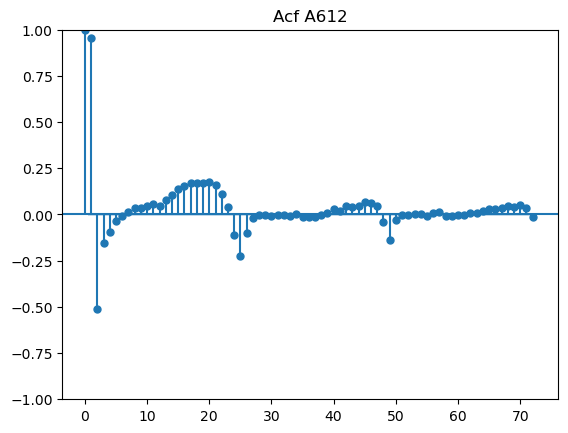

In [38]:
_ = plot_pacf(df_just_stocastic.iloc[:,1],lags=72)
_ = plt.title('Acf '+ df_just_stocastic.columns[1])
_ = plot_pacf(df_just_stocastic.iloc[:,2],lags=72)
_ = plt.title('Acf '+ df_just_stocastic.columns[2])
_ = plot_pacf(df_just_stocastic.iloc[:,3],lags=72)
_ = plt.title('Acf '+ df_just_stocastic.columns[3])
_ = plot_pacf(df_just_stocastic.iloc[:,4],lags=72)
_ = plt.title('Acf '+ df_just_stocastic.columns[4])

Após analisar os gráficos ACF e PACF, a percebemos uma correlação negativa entre as variáveis volume da chuva com temperatura máxima.
e uma correlação posivita com a pressão, porém é muito baixa.## Modelo

### Cross Correlation

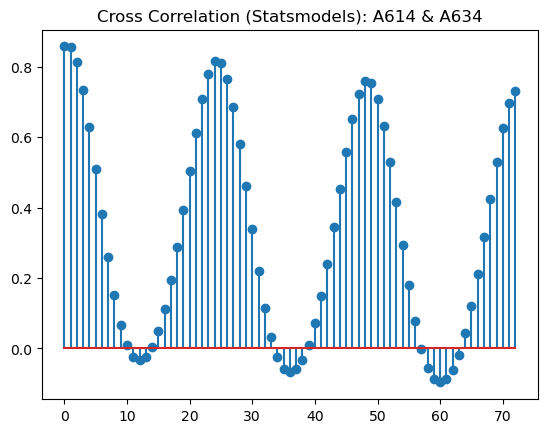

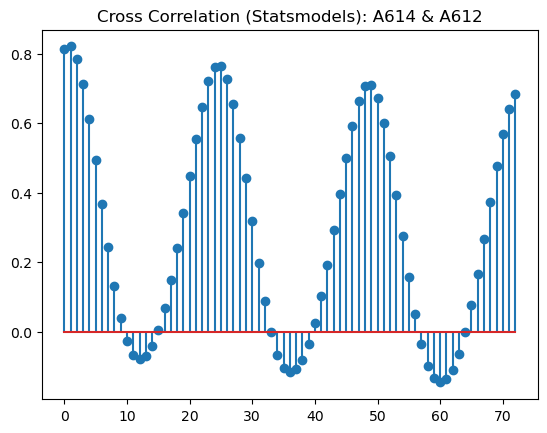

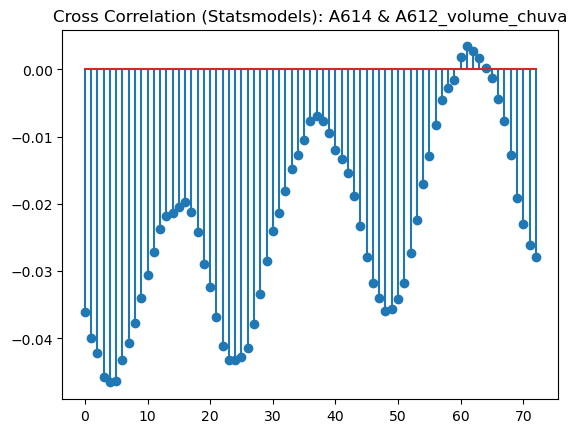

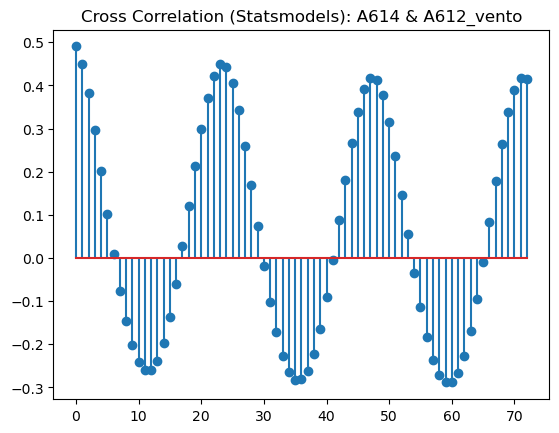

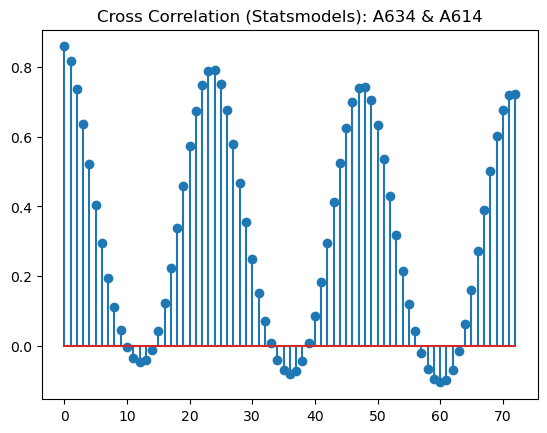

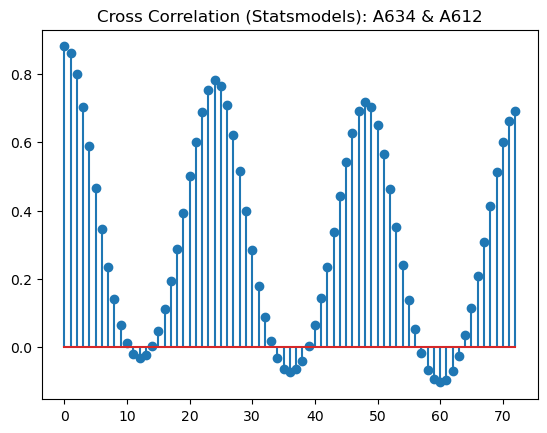

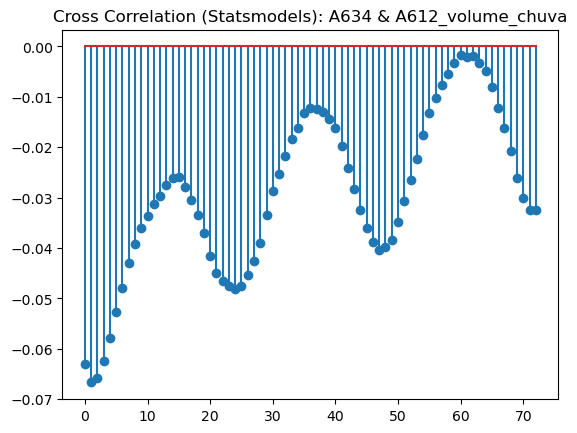

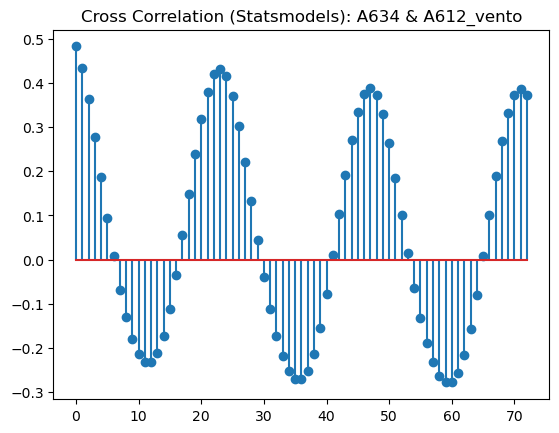

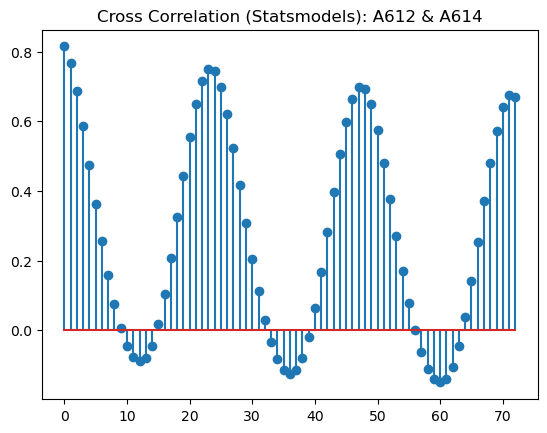

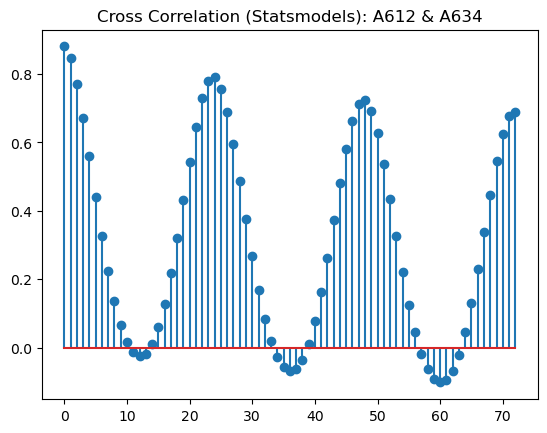

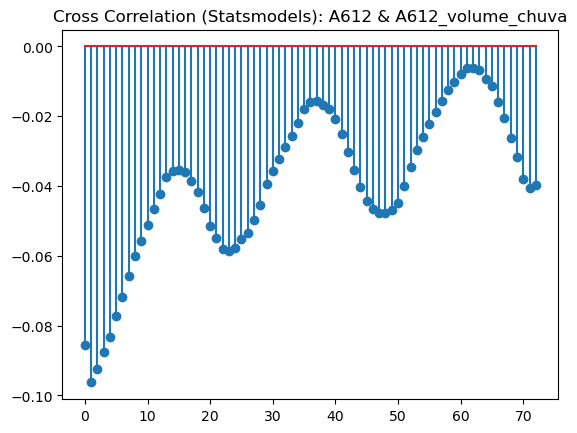

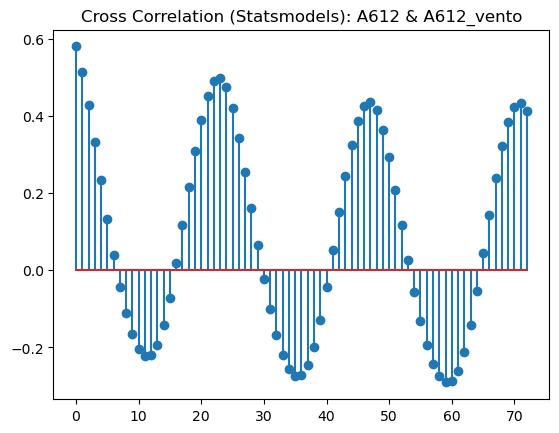

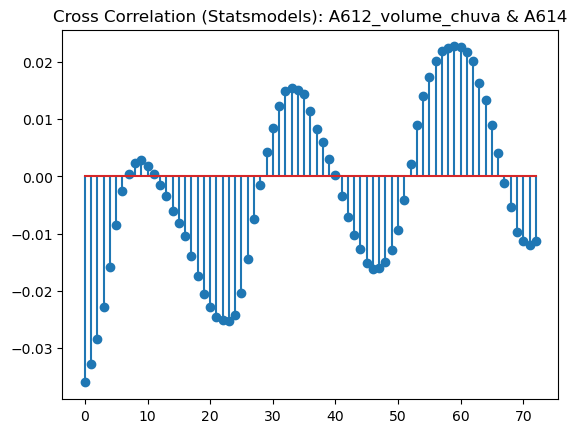

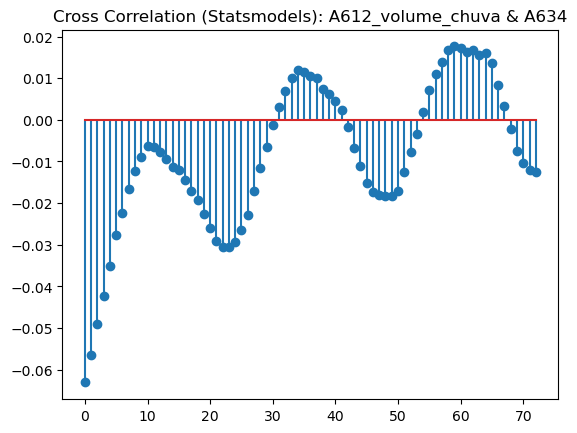

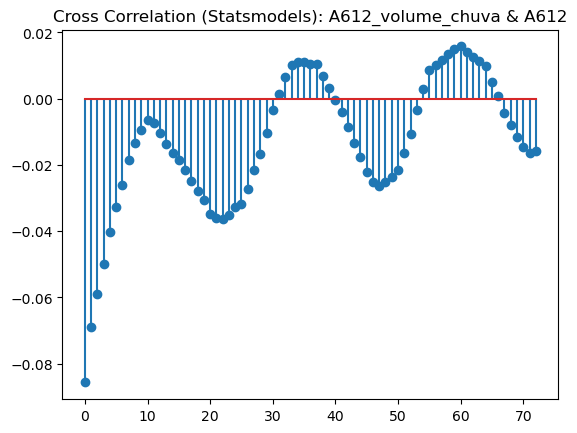

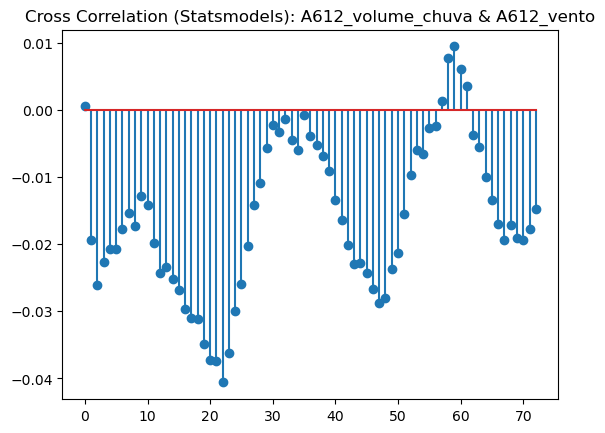

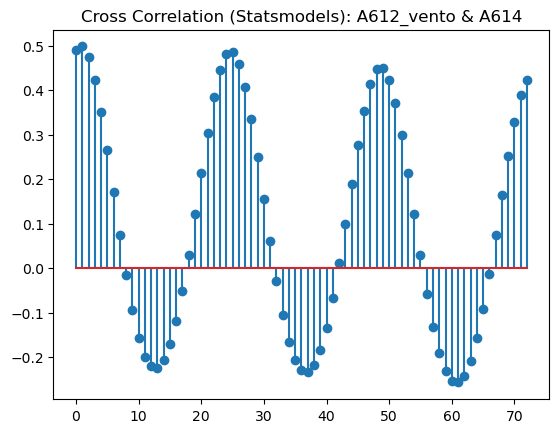

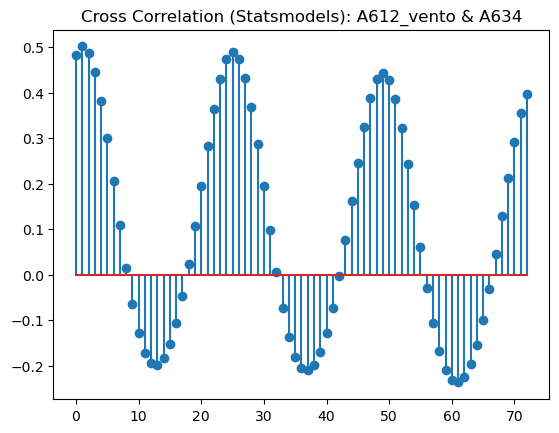

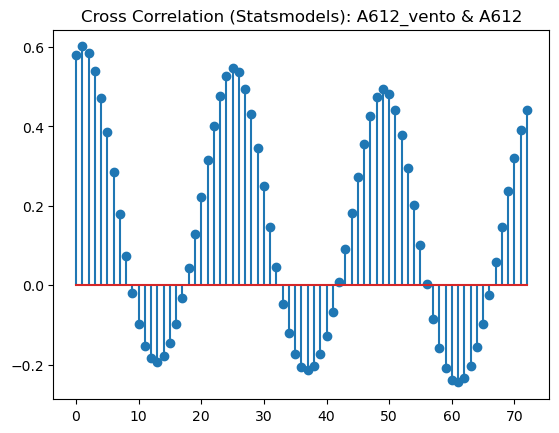

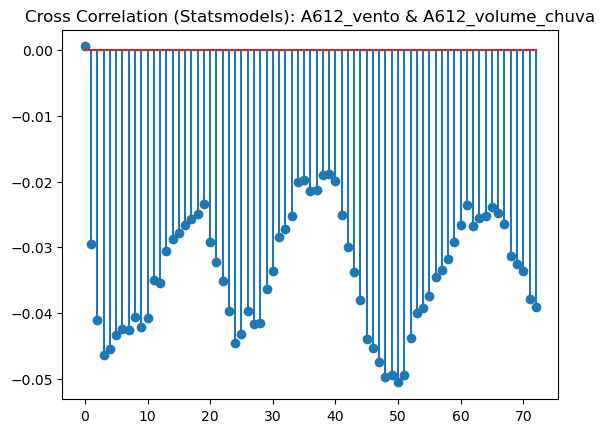

In [67]:
cross_plots(variables[['A614', 'A634','A612', 'A612_volume_chuva','A612_vento']])

In [42]:
from statsmodels.tsa.api import VAR

In [54]:
variables.index = df_just_stocastic.date_time
variables2 = variables.resample('D').mean()

In [62]:
model = VAR(variables2.iloc[:,:4],variables2.iloc[:,4:])
fit = model.fit(maxlags=4)
fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 06, Feb, 2023
Time:                     20:10:18
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -1.97681
Nobs:                     1531.00    HQIC:                  -2.23054
Log likelihood:          -6750.98    FPE:                  0.0924661
AIC:                     -2.38093    Det(Omega_mle):       0.0857798
--------------------------------------------------------------------
Results for equation A613
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                   117.621637        11.213055           10.490           0.000
A613_volume_chuva        -0.080485         0.043714           -1.841           0.066
A614_volume_chuva        -0.418809         0.

## Conclusão

Mantivemos velocidade do vento, pressão atmosferica, precipitação no modelo, vemos que todos são bem relevantes para as proprias cidades e alguns são apareceram relevantes para cidades proximas. Mais proximo mais esperado das coisas darem relevantes.  
Vemos que as temperaturas se explicam bem, quando adicionamos as outras covariaveis elas todas se tornam significativas em pelo menos 1 dos 4 modelos, principalemnte os das mesmas cidades.  
Talvez resumir a serie por dia ou utilizar a sazonalidade melhor, evoluir o modelo para um SARIMA para proximos estudos. Não adicionamos formas de absorver a sazonalidade que encontramos mesmo que o modelo tenha se saido bem.